In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyport.portopt import opt, objfunc
from pyport.portbt import PyBacktest
import pyport.portstats as stats

In [3]:
from pandas_datareader import data

In [4]:
"""Define parameters for data request."""

tickers = ['AGG', 'EBND', 'URTH', 'EEM']
data_source = 'yahoo'
start_date = '2014-03-31'
end_date = '2018-03-31'

In [5]:
"""Request data, ensure sorted by ascending date, and normalise."""

panel_data = data.DataReader(tickers, data_source, start_date, end_date)
px_data = panel_data.loc['Adj Close'].dropna().sort_index(ascending=True)
px_data = px_data / px_data.iloc[0]

In [6]:
"""
TEST CASE
Add constraints: Portfolio weights must sum to 100%, minimum ann. volatility target == 5.0%,
Add boundaries: Long only, no short positions.
"""

vol_trgt = 0.05

cons = [
   {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
   {'type': 'eq', 'fun': lambda w: stats.vol(px_data, w) - vol_trgt}
]

bnds = [(0, 1) for x in px_data.columns]

In [7]:
"""Run optimisation."""

opt_result = opt.port_optimisation(objfunc.max_sr, px_data, rf=0.0, scaling_fact=252, constraints=cons, bounds=bnds)

Optimization terminated successfully. Success==True after 5 iterations.
Total time: 0.1192464828491211 secs


In [8]:
"""View optimised weights."""

opt_result['weights']

array([  6.34661344e-01,   1.55638069e-17,   0.00000000e+00,
         3.65338656e-01])

In [9]:
"""Initialise backtest class."""

rf = 0.0
bt = PyBacktest(px_data, opt_period = 365, val_period = 90, rf=rf, scaling_fact=252)

In [10]:
"""Generate historical optimisation weights."""

max_er = bt.bt_optimisation(objfunc.max_er, constraints=cons, bounds=bnds)
max_er_ts = bt.bt_timeseries()

min_vol = bt.bt_optimisation(objfunc.min_vol, constraints=cons, bounds=bnds)
min_vol_ts = bt.bt_timeseries()

max_sr = bt.bt_optimisation(objfunc.max_sr, constraints=cons, bounds=bnds)
max_sr_ts = bt.bt_timeseries()

risk_parity = bt.bt_optimisation(objfunc.risk_parity, constraints=cons, bounds=bnds)
risk_parity_ts = bt.bt_timeseries()

max_dr = bt.bt_optimisation(objfunc.max_dr, constraints=cons, bounds=bnds)
max_dr_ts = bt.bt_timeseries()

Total time: 1.8209044933319092 secs
Total time: 2.4683711528778076 secs
Total time: 1.4105772972106934 secs
Total time: 1.8372645378112793 secs
Total time: 1.8503801822662354 secs


In [11]:
"""Create df of individual results."""

comp_df = pd.concat([max_er_ts.MV, min_vol_ts.MV, max_sr_ts.MV, risk_parity_ts.MV, max_dr_ts.MV], axis=1)
comp_df.columns = ['max_er', 'min_vol', 'max_sr', 'risk_parity', 'max_dr']

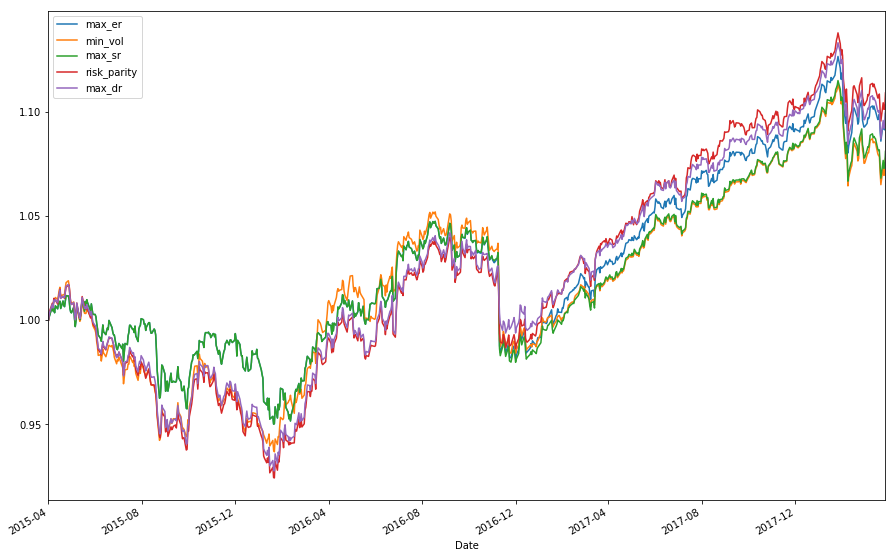

In [12]:
"""Plot and compare optimisation results."""

comp_df.plot(figsize=(15,10))
plt.legend(loc='best');

In [13]:
"""View summary statistics."""

stats.stats_summary(comp_df, rf=rf)

,max_er,min_vol,max_sr,risk_parity,max_dr
cumu_return,0.099196,0.077626,0.080972,0.109006,0.100257
ann_return,0.032088,0.025280,0.026342,0.035155,0.032421
volatility,0.053529,0.051236,0.053583,0.051204,0.050699
sharpe_ratio,0.599454,0.493397,0.491609,0.686570,0.639475
max_drawdown,-0.062735,-0.080538,-0.064564,-0.091025,-0.087887
